In [1]:
# from geomloss import SamplesLoss

In [1]:
import numpy as np
import pandas as pd
import sys
import torch.nn as nn
import torch.nn.functional as F

import math
import torch
import madgrad
import torch.autograd as auto
sys.path.append("./set_transformer")
from modules import ISAB, PMA, SAB
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from torch.optim import Optimizer

In [2]:
from sklearn.model_selection import train_test_split
def build_dataset():
    data_gpaw = pd.read_pickle("data/gpaw_forces_dataframe.pickle")
    data_vasp = pd.read_pickle("data/VASP_MoS2_defects.pickle")
    assert (data_vasp.structures.iloc[0].lattice._matrix == data_gpaw.structure.iloc[0].cell.array).all()
    
    positions = np.concatenate([i.positions[np.newaxis, :, :] for i in data_gpaw.structure] +
                               [i.cart_coords[np.newaxis, :, :] for i in data_vasp.structures],
                               axis=0).astype(np.float32)
    #positions -= positions.mean(axis=(0,1), keepdims=True)
    #positions /= positions.std(axis=(0,1), keepdims=True)
    
    energies = np.concatenate([data_gpaw.energy.values, data_vasp.energy.values]).astype(np.float32)
#     energies -= energies.mean()
    energies = energies.reshape(-1, 1)
    transformer = RobustScaler().fit(energies)

    energies = transformer.transform(energies)


    forces = np.concatenate([f[np.newaxis, :, :] for f in data_gpaw.forces] +
                            [np.zeros((len(data_vasp), positions.shape[1], positions.shape[2]), dtype=np.float32)],
                            axis=0).astype(np.float32)
    
    types = np.concatenate([i.get_atomic_numbers()[np.newaxis, :] for i in data_gpaw.structure] + 
                           [np.array(i.atomic_numbers)[np.newaxis, :] for i in data_vasp.structures],
                           axis=0).astype(np.int32)
    return list(map(np.array,
                    train_test_split(positions, types, energies, forces, test_size=0.25, random_state=1421))),\
           data_gpaw.structure.iloc[0].cell.array.astype(np.float32)

In [3]:
def fixup_initialization(args):
    temp_state_dic = {}
    en_layers = args.encoder_layers
    de_layers = args.decoder_layers

    if args.Tfixup:
        for name, param in self.named_parameters():
            if name in ["fc1.weight",
                        "fc2.weight",
                        "self_attn.out_proj.weight",
                        ]:
                temp_state_dic[name] = (0.67 * (en_layers) ** (- 1. / 4.)) * param
            elif name in ["self_attn.v_proj.weight",]:
                temp_state_dic[name] = (0.67 * (en_layers) ** (- 1. / 4.)) * (param * (2**0.5))

    for name in self.state_dict():
        if name not in temp_state_dic:
            temp_state_dic[name] = self.state_dict()[name]
    self.load_state_dict(temp_state_dic)
    

# temp_state_dict = embed_tokens.state_dict()
# temp_state_dict["weight"] = (9 * args.encoder_layers) ** (- 1 / 4) * temp_state_dict["weight"]
# embed_tokens.load_state_dict(temp_state_dict)

In [4]:
class SetTransformer(nn.Module):
    def __init__(
        self,
        dim_input=4,
        num_outputs=1,
        dim_output=1,
        num_inds=32,
        dim_hidden=128,
        num_heads=16,
        ln=False,
    ):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
            ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
#             ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
#             ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
        )
        self.dec = nn.Sequential(
            PMA(dim_hidden, num_heads, num_outputs, ln=ln),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, dim_output),
        )

    def forward(self, X):
        return self.dec(self.enc(X)).squeeze()

In [5]:
from sklearn.model_selection import train_test_split
def build_dataset():
    data_gpaw = pd.read_pickle("data/gpaw_forces_dataframe.pickle")
    data_vasp = pd.read_pickle("data/VASP_MoS2_defects.pickle")
    assert (data_vasp.structures.iloc[0].lattice._matrix == data_gpaw.structure.iloc[0].cell.array).all()
    
    positions = np.concatenate([i.positions[np.newaxis, :, :] for i in data_gpaw.structure] +
                               [i.cart_coords[np.newaxis, :, :] for i in data_vasp.structures],
                               axis=0).astype(np.float32)
    #positions -= positions.mean(axis=(0,1), keepdims=True)
    #positions /= positions.std(axis=(0,1), keepdims=True)
    
    energies = np.concatenate([data_gpaw.energy.values, data_vasp.energy.values]).astype(np.float32)
#     energies -= energies.mean()
    energies = energies.reshape(-1, 1)
    transformer = RobustScaler().fit(energies)

    energies = transformer.transform(energies)


    forces = np.concatenate([f[np.newaxis, :, :] for f in data_gpaw.forces] +
                            [np.zeros((len(data_vasp), positions.shape[1], positions.shape[2]), dtype=np.float32)],
                            axis=0).astype(np.float32)
    
    types = np.concatenate([i.get_atomic_numbers()[np.newaxis, :] for i in data_gpaw.structure] + 
                           [np.array(i.atomic_numbers)[np.newaxis, :] for i in data_vasp.structures],
                           axis=0).astype(np.int32)
    return list(map(np.array,
                    train_test_split(positions, types, energies, forces, test_size=0.25, random_state=1421))),\
           data_gpaw.structure.iloc[0].cell.array.astype(np.float32)

positions.shape = (616, 105, 3)
<E> = -0.7444171905517578


In [6]:
inputs_t = torch.tensor(np.concatenate([positions, np.expand_dims(species, -1)], axis=2), requires_grad=True).cuda()
energies_t = torch.tensor(energies).cuda()
forces_t = torch.tensor(forces).cuda()

In [8]:
model = SetTransformer(dim_hidden=256, num_heads=4, num_inds=16).cuda()
model.load_state_dict(torch.load('checkpoints/checkpoint_3100.pth'), strict=True)

<All keys matched successfully>

In [9]:
def get_cosine_schedule_with_warmup(
    optimizer: Optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: float = 0.5, last_epoch: int = -1
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, gamma=0.9)
# scheduler = get_cosine_schedule_with_warmup(optimizer, 500, 5000)

force_coefficient = 0.9
losses_en = []
losses_f = []


model.train()
for iteration in range(5000):
    preds = model(inputs_t)
    energies_t = energies_t.reshape(-1)
    mse_en = F.mse_loss(preds, energies_t)
#     l1 = l1(preds, energies_t)
    pred_forces = - auto.grad(preds.sum(), inputs_t, retain_graph=True,
                        create_graph=True)[0]
    mse_f = F.mse_loss(pred_forces[..., :3], forces_t)

    loss = mse_en + force_coefficient * mse_f
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_en.append(mse_en.item())
    losses_f.append(mse_f.item())
    
    if iteration % 100 == 0:
        torch.save(model.state_dict(), f'checkpoints/checkpoint_{iteration}.pth')
        

    
    print(f"{iteration}  LR: {scheduler.get_last_lr()[0]:.6f}  loss: {loss.cpu().detach().item()} Energy RMSE: {np.sqrt(losses_en[-1]):.3f} eV \
        Force RMSE: {np.sqrt(losses_f[-1]):.3f} eV", end='\r')
    

In [11]:
# # Save model
# torch.save(model.state_dict(), 'data/finetune_cos_warmup_0.xxx_ev.pth')
# # Just incase...
# torch.save(optimizer.state_dict(), 'data/finetune_cos_warmup_optim_0.xxx_ev.pth')

In [13]:
# # Save model
# torch.save(model.state_dict(), 'data/final_finetune_cos_warmup_0.0.183_ev.pth')
# # Just incase...
# torch.save(optimizer.state_dict(), 'data/final_finetune_cos_warmup_optim_0.0.183_ev.pth')

(0.0, 2.0)

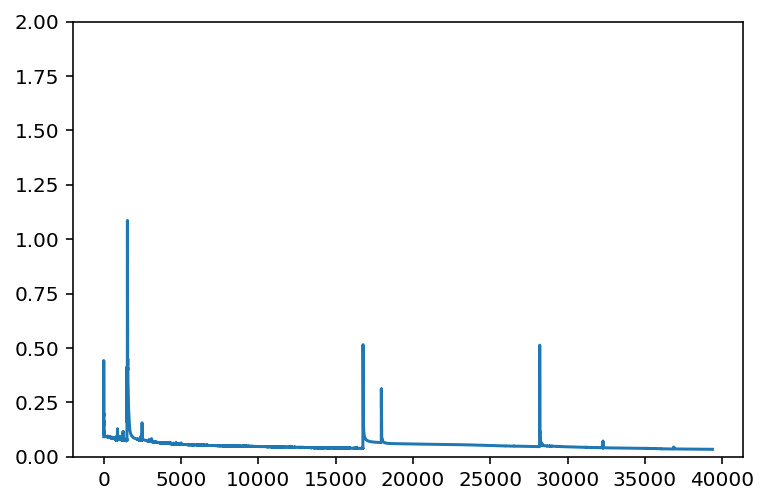

In [14]:
plt.plot(losses_en)
plt.ylim(0, 2)

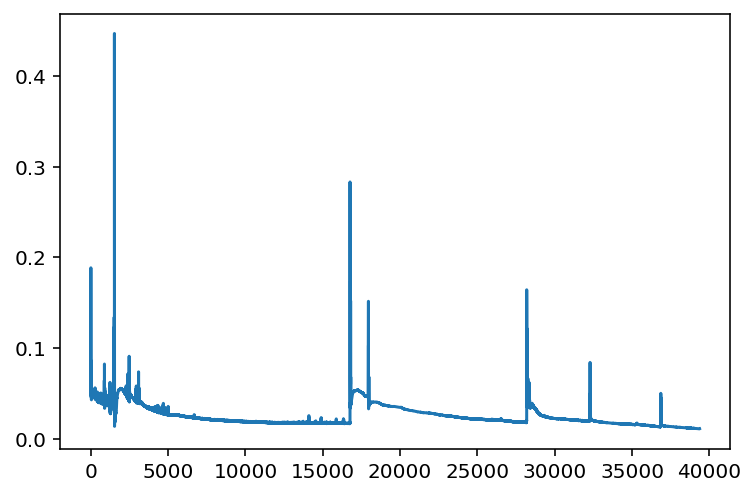

In [15]:
plt.plot(losses_f)
# plt.ylim(0, 2)

In [16]:
preds_np = preds.cpu().detach().numpy()

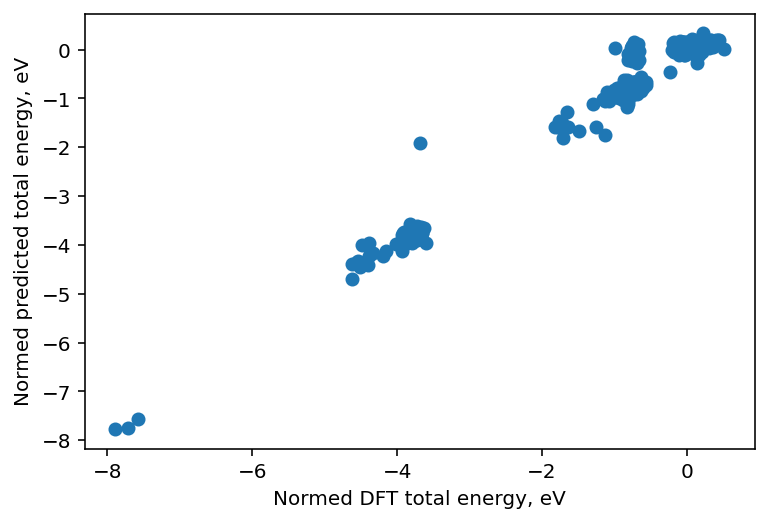

In [17]:
fig, ax = plt.subplots()
ax.scatter(energies, preds_np)
ax.set_ylabel("Normed predicted total energy, eV")
ax.set_xlabel("Normed DFT total energy, eV");

In [ ]:
fig, ax = plt.subplots()
ax.scatter(energies, preds_np)
ax.set_ylabel("Normed predicted total energy, eV")
ax.set_xlabel("Normed DFT total energy, eV");

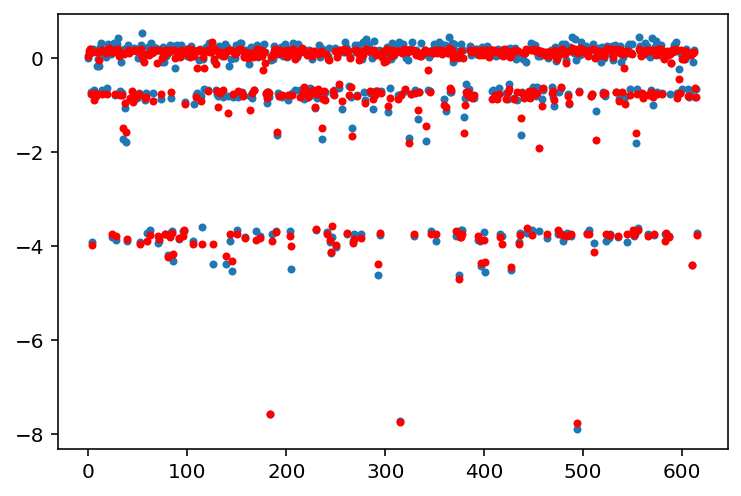

In [18]:
plt.plot(energies, '.')
plt.plot(preds_np, 'r.')

In [43]:
# testing
(positions, test_positions, \
types, test_types, \
energies, test_energies, \
forces, test_forces), lattice = build_dataset()
species = (test_types==test_types[0,0]).astype(np.float32)
energy_mean_test = np.mean(test_energies)
print('positions.shape = {}'.format(test_positions.shape))
print('<E> = {}'.format(energy_mean_test))


inputs_test = torch.tensor(np.concatenate([test_positions, np.expand_dims(species, -1)], axis=2), requires_grad=True).cuda()
energies_test = torch.tensor(test_energies)
preds_test = model(inputs_test)

print(f'Test rmse: {torch.nn.MSELoss()(energies_test.reshape(-1), preds_test.cpu()).sqrt().item()} ev')

positions.shape = (206, 105, 3)
<E> = -0.8725791573524475
Test rmse: 0.32774654030799866 ev


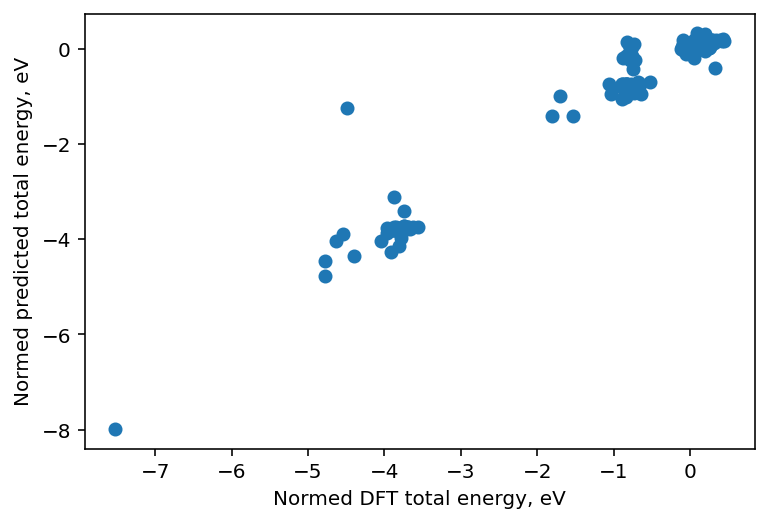

In [44]:
preds_test_ = preds_test.cpu().detach().numpy()
fig, ax = plt.subplots()
ax.scatter(energies_test, preds_test_)
ax.set_ylabel("Normed predicted total energy, eV")
ax.set_xlabel("Normed DFT total energy, eV");


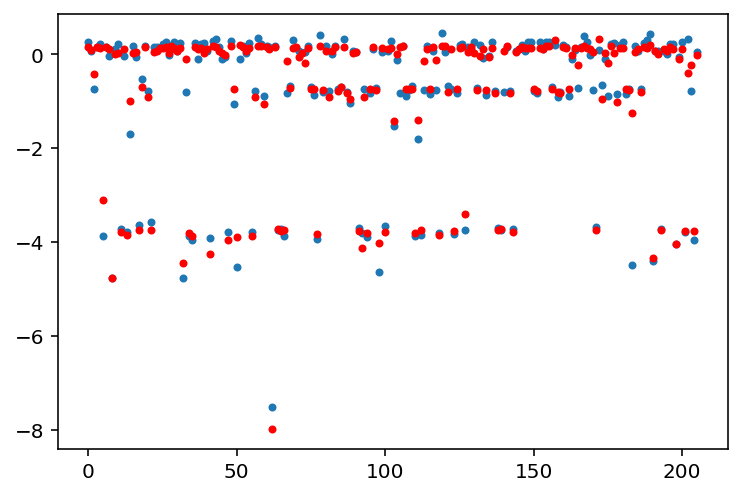

In [45]:
plt.plot(energies_test, '.')
plt.plot(preds_test_, 'r.')

In [46]:
test_positions_ = torch.tensor(test_positions, requires_grad=True).cuda()

In [47]:
force = - auto.grad(preds_test.sum(), inputs_test)[0]
force_ = force[..., :3].cpu().numpy()

In [48]:
np.sqrt(((test_forces - force_)**2).mean())

0.20096627

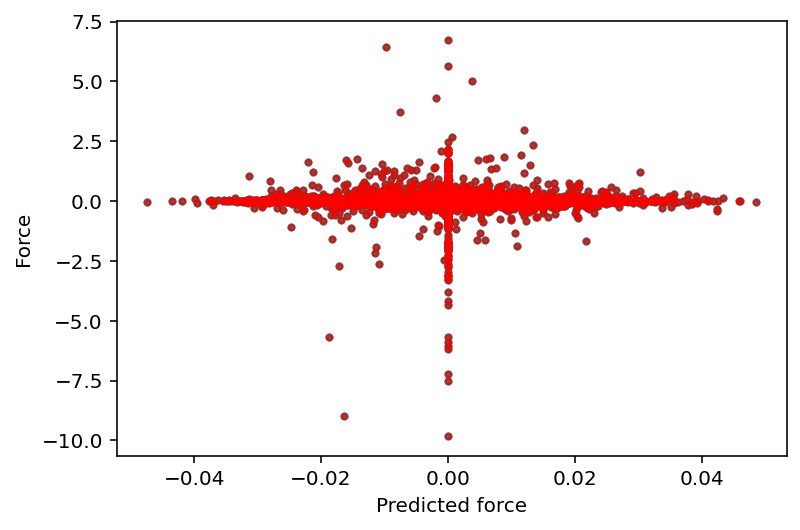

In [49]:
fig, ax = plt.subplots()
ax.plot(test_forces[..., 0], force_[..., 0], 'b.', alpha=0.5)
ax.plot(test_forces[..., 0], force_[..., 0], 'g.', alpha=0.5)
ax.plot(test_forces[..., 0], force_[..., 0], 'r.', alpha=0.5)

ax.set_ylabel("Force")
ax.set_xlabel("Predicted force");


In [ ]:
#Hyperparameter search...

In [ ]:
import optuna
import logging

In [ ]:
inputs_t = torch.Tensor(np.concatenate([positions, np.expand_dims(species, -1)], axis=2)).cuda()
energies_t = torch.Tensor(energies).cuda()

def objective(trial):
    lr = trial.suggest_uniform('lr', 1e-6, 1e-3)
    
    model = SetTransformer(dim_hidden=256, num_heads=16).cuda()
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
    optimizer = madgrad.MADGRAD(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-6,
#                                                 anneal_strategy='linear', div_factor=100,
#                                                 steps_per_epoch=1,
#                                                 epochs=5000)

    losses = []
    mse = torch.nn.MSELoss()#SamplesLoss("laplacian", blur=0.1)
    l1 = torch.nn.L1Loss()
    model.train()
    for iteration in range(10):
        preds = model(inputs_t)
    #     loss = criterion(preds.unsqueeze(0).view(1, -1, 1), energies_t.unsqueeze(0))
        global energies_t
        energies_t = energies_t.reshape(-1)
        l2 = mse(preds, energies_t)
        loss = l2 + l1(preds, energies_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     scheduler.step()
        losses.append(l2.item())
        print(f"{iteration}  Train RMSE {np.sqrt(losses[-1]):.3f} eV", end='\r')
    return np.sqrt(losses[-1])
    

In [ ]:
pruner: optuna.pruners.BasePruner = (optuna.pruners.MedianPruner())
    
logging.basicConfig(filename='search.log', level=logging.INFO)

def print_best_callback(study, trial):
    with open('search.log', 'a+') as file:
        file.writelines(f"Best value: {study.best_value}, Best params: {study.best_trial.params}") 
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=300, n_jobs=1, callbacks=[print_best_callback])

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
torch.tensor(float('inf'))

In [ ]:
study.optimize